# Week 3 Check-In
## Team Spotiflies: Joanna, Aaron, Aubrey, Kennedy, Aster, Ethan
GitHub Link: https://github.com/ketexon/csm148-spotiflies

In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn mlxtend

Note: you may need to restart the kernel to use updated packages.


### Variable Selection
We used the cleaned version of our dataset from the week 2 check in. For our response variable, we chose `mode` because it had less class imbalance, so it would lead to a better logistic regression model.

We chose to use `valence` as our predictor variable due to our domain knowledge. `valence` is a measure of how happy a track is, and `mode` is whether the track is in a major (1) or minor(0) key. Major keys are generally regarded as being happier than minor keys, so we were curious if the data supported this.

In [77]:
import pandas as pd

# Reading in the cleaned data from previous week check in
spotify = pd.read_csv("csv_outputs/cleaned_spotify.csv")

# check the class imbalance of the two binary values
print(spotify['mode'].value_counts())
print(spotify['explicit'].value_counts())

# select the variables of interest
numeric_spotify = spotify[['mode', 'valence']]
numeric_spotify

mode
1    72681
0    41318
Name: count, dtype: int64
explicit
False    104252
True       9747
Name: count, dtype: int64


,mode,valence
0,0,0.7150
1,1,0.2670
2,1,0.1200
3,1,0.1430
4,1,0.1670
...,...,...
113994,1,0.0339
113995,0,0.0350
113996,0,0.7430
113997,1,0.4130


### Logistic Regression

[0.48593023] [[0.17089804]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Probability of Major Key')

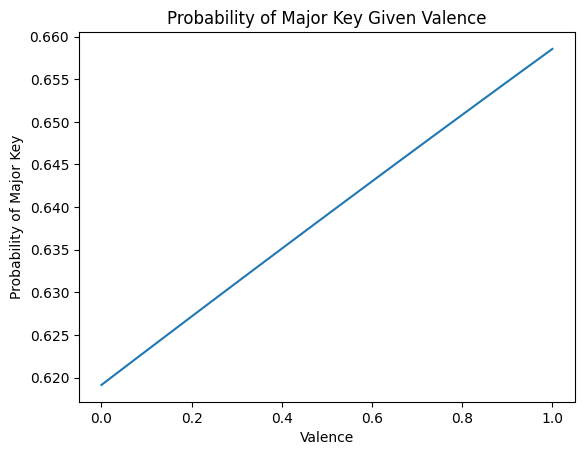

In [80]:
# Modeling regression of valence vs mode
# We are doing a logistic regression analysis.

# Import necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

random_seed = 42
response = "mode"
predictor = 'valence'

# Splitting the data
# First split: separate out 20% for the test set
spotify_train_val, spotify_test = train_test_split(numeric_spotify, test_size=0.2, random_state=random_seed)

# Second split: separate remaining 80% into 60% training and 40% validation
spotify_train, spotify_val = train_test_split(spotify_train_val, test_size=0.25, random_state=random_seed)  # 0.25 * 0.8 = 0.2

# Reshape the data to fit the model
X_train = spotify_train.drop(columns=response)
y_train = spotify_train[response]

# fit the model and list intercept and coefficient
logistic_reg = LogisticRegression(solver='liblinear')
logistic_reg.fit(X=X_train,y=y_train)
print(logistic_reg.intercept_, logistic_reg.coef_)


# generate values for plotting the curve
x_values = np.linspace(0, 1, 100)
y_values = logistic_reg.predict_proba(x_values.reshape(-1, 1))[:,1]

# plot the curve
plt.plot(x_values, y_values)
plt.title('Probability of Major Key Given Valence')
plt.xlabel('Valence')
plt.ylabel("Probability of Major Key")

### Calculating the Confusion Matrix + Metrics

In [90]:
# calculate the confusion matrix using the validation set
y_pred = logistic_reg.predict(spotify_val.drop(columns=response))
y_true = spotify_val[response]
conf = metrics.confusion_matrix(y_pred=y_pred, y_true=y_true)
print('confusion matrix:\n', conf)
print('Prediction Accuracy:', metrics.accuracy_score(y_true=y_true, y_pred=y_pred))
print('Prediction Error:', 1 - metrics.accuracy_score(y_true=y_true, y_pred=y_pred))
print('True Positive Rate:', metrics.recall_score(y_true=y_true, y_pred=y_pred))
print('True Negative Rate:', metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label=0))

confusion matrix:
 [[    0  8276]
 [    0 14524]]
Prediction Accuracy: 0.6370175438596491
Prediction Error: 0.36298245614035085
True Positive Rate: 1.0
True Negative Rate: 0.0


### ROC Curve + AUC Calculation

In [97]:
import plotly.express as px

# Create the ROC curve variables
logistic_reg_fpr_sample, logistic_reg_tpr_sample, logistic_reg_thresholds_sample = metrics.roc_curve(spotify_val[response], logistic_reg.predict_proba(spotify_val.drop(columns=response))[:,1])
roc_logistic_reg_sample = pd.DataFrame({
    'False Positive Rate': logistic_reg_fpr_sample,
    'True Positive Rate': logistic_reg_tpr_sample,
    'Model': 'Logistic Regression'
}, index=logistic_reg_thresholds_sample)
roc_sample_df = pd.concat([roc_logistic_reg_sample])

# Plot
px.line(roc_sample_df, y='True Positive Rate', x='False Positive Rate',
        color='Model',
        width=700, height=500
)

# Calculate AUC
logistic_reg_auc_sample = metrics.roc_auc_score(spotify_val[response], logistic_reg.predict_proba(spotify_val.drop(columns=response))[:,1])
print('Logistic regression AUC:', logistic_reg_auc_sample.round(3))

Logistic regression AUC: 0.511


### 5-Fold CV + AUC Calculation

In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5)
i = 1
X = spotify_val.drop(columns=response)
y = spotify_val[response]
for train_index, test_index in skfolds.split(X, y):
    clone_lr = clone(logistic_reg)
    X_train_folds = X.iloc[train_index]
    y_train_folds = y.iloc[train_index]
    X_test_fold = X.iloc[test_index]
    print(test_index)
    clone_lr.fit(X_train_folds, y_train_folds)
    y_pred = clone_lr.predict(X_test_fold)

    auc_sample = metrics.roc_auc_score(y.iloc[test_index], y_pred)
    print('Fold: ', i)
    print('AUC: ', auc_sample)
    print('Accuracy: ', metrics.accuracy_score(y.iloc[test_index], y_pred))
    i += 1

[   0    1    2 ... 4661 4662 4670]
Fold:  1
AUC:  0.5
Accuracy:  0.6370614035087719
[4491 4492 4493 ... 9161 9164 9167]
Fold:  2
AUC:  0.5
Accuracy:  0.6370614035087719
[ 9086  9089  9092 ... 13753 13754 13757]
Fold:  3
AUC:  0.5
Accuracy:  0.6370614035087719
[13641 13642 13643 ... 18306 18310 18311]
Fold:  4
AUC:  0.5
Accuracy:  0.6370614035087719
[18216 18218 18219 ... 22797 22798 22799]
Fold:  5
AUC:  0.5
Accuracy:  0.6368421052631579
